In [1]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

Check if CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.empty_cache()

## Test the model

In [5]:
import pickle

In [6]:
with open('filename.pickle', 'rb') as handle:
    maskbbox = pickle.load(handle)

In [7]:
labels_names=os.listdir('data/training/label_2/')

In [8]:
labels_names.sort()

In [9]:
val_labels=open("val.txt", "r").read().split('\n')

In [10]:
gt = []
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('data/training/label_2/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        for line in temp:
            if line[0]=='Pedestrian':
                gt.append([i, float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[-2])])
print(len(gt))

2280


In [11]:
maskbbox=np.delete(maskbbox, (0), axis=0)

In [12]:
mask_val_bbox = []
for i in maskbbox:
    if int(i[0]) in list(map(int, val_labels)):
        mask_val_bbox.append(i)
        

In [13]:
maskbbox=np.array(mask_val_bbox)
print(len(maskbbox))

2547


In [14]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    return (top-bottom)*(right-left)


In [15]:
def get_union_area(r1, r2):
    return (r1[2]-r1[0])*(r1[3]-r1[1]) + (r2[2]-r2[0])*(r2[3]-r2[1]) - get_inter_area(r1, r2)

In [16]:
gt=np.array(gt)

In [19]:
all_images = list(set(gt[:,0].astype(int)))
final_boxes = []
for i in all_images:
    if len(gt[gt[:,0]==i])==0 or len(maskbbox[maskbbox[:,0]==i])==0:
        continue
    inter_matrix = np.zeros((len(gt[gt[:,0]==i]),len(maskbbox[maskbbox[:,0]==i])))
    for l, tbbox in enumerate(gt[gt[:,0]==i]):
        for k, mbbox in enumerate(maskbbox[maskbbox[:,0]==i]):
            inter_matrix[l,k]=get_inter_area(tbbox[1:5], mbbox[1:])/get_union_area(tbbox[1:5], mbbox[1:])
    for l in range(len(inter_matrix)):
        if inter_matrix[l][np.argmax(inter_matrix[l])]>0.3:
            final_boxes.append(np.append(maskbbox[maskbbox[:,0]==i][np.argmax(inter_matrix[l])],gt[gt[:,0]==i][l,-1])) 
            inter_matrix[:,np.argmax(inter_matrix[l])] = 0

In [25]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':True,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

Use a dataset with 7481 images


In [18]:
model_test.test()

Finished Testing


In [17]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(7481, 256, 512)

In [20]:
np.array(final_boxes).shape

(1538, 6)

In [21]:
all_errors = [[] for _ in range(100)]

for box in final_boxes:
    disp_to_img = skimage.transform.resize(disp[int(box[0])].squeeze(), [375, 1242], mode='constant')
    depth = 0.54 * 721 / (1242 * disp_to_img)
    for i, errors in enumerate(all_errors):
        #pred=depth[int(((box[1+1]+box[3+1])/2)-(box[3+1]-box[1+1])/(i+2)):int(((box[1+1]+box[3+1])/2)+(box[3+1]-box[1+1])/(i+2)),
        #           int(((box[0+1]+box[2+1])/2)-(box[2+1]-box[0+1])/(i+2)):int(((box[0+1]+box[2+1])/2)+(box[2+1]-box[0+1])/(i+2))].mean()
        pred=depth[int(((box[1+1]+box[3+1])/2)):int(((box[1+1]+box[3+1])/2)+i+2),
                   int(((box[0+1]+box[2+1])/2)):int(((box[0+1]+box[2+1])/2)+i+2)].mean()
        
        gtruth=box[-1]

        errors.append([gtruth,pred,pred-gtruth,int(box[0])])


In [22]:
for i, errors in enumerate(all_errors):
    errors=np.array(errors)
    print(i+2,'average error in m: ', abs(errors[:,2]).mean())

2 average error in m:  3.83428362315
3 average error in m:  3.72557794193
4 average error in m:  3.62897300906
5 average error in m:  3.5462662405
6 average error in m:  3.47667657531
7 average error in m:  3.41439949428
8 average error in m:  3.3593314753
9 average error in m:  3.30856445407
10 average error in m:  3.26133461238
11 average error in m:  3.21958219421
12 average error in m:  3.1828965986
13 average error in m:  3.14922759974
14 average error in m:  3.1199756276
15 average error in m:  3.09438475312
16 average error in m:  3.07256964994
17 average error in m:  3.05413595882
18 average error in m:  3.04072675969
19 average error in m:  3.03047899414
20 average error in m:  3.02115760664
21 average error in m:  3.01307749822
22 average error in m:  3.00675209699
23 average error in m:  3.00059337595
24 average error in m:  2.99441135533
25 average error in m:  2.98770831608
26 average error in m:  2.98015875117
27 average error in m:  2.97331329731
28 average error in m:  

In [23]:
errors = np.array(all_errors[47])

In [24]:
clean_errors = errors[abs(errors[:,2])<20]

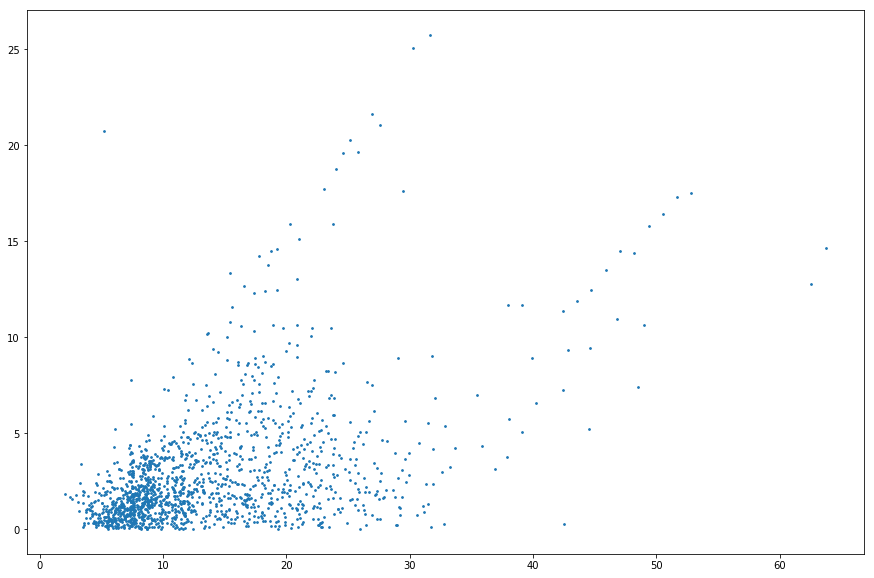

In [25]:
plt.scatter(errors[:,0],abs(errors[:,2]),s=3)
plt.show()

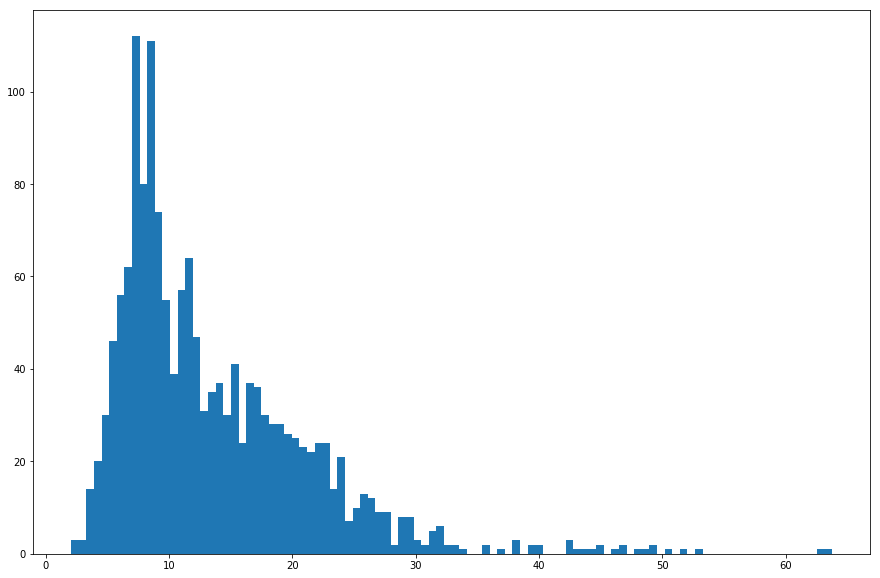

In [26]:
plt.hist(errors[:,0], bins=100)
plt.show()

In [27]:
print('average error in m: ', abs(errors[:,2]).mean())
print('median error in m: ', np.median(abs(errors[:,2])),'\n')

print('smaller than 0.5m: ', len(errors[abs(errors[:,2])<0.5])/len(gt)*100,'%')
print('smaller than 1m: ', len(errors[abs(errors[:,2])<1])/len(gt)*100,'%')
print('smaller than 2m: ', len(errors[abs(errors[:,2])<2])/len(gt)*100,'%\n')

print('the recall is: ', len(errors)*100/len(gt),'%')
print('the rate of false positives is: ',(len(maskbbox)-len(errors))*100/len(maskbbox),'%')

average error in m:  2.78948874971
median error in m:  1.87325820403 

smaller than 0.5m:  8.596491228070176 %
smaller than 1m:  17.719298245614034 %
smaller than 2m:  35.833333333333336 %

the recall is:  67.45614035087719 %
the rate of false positives is:  39.61523360816647 %


In [28]:
temp_errors=errors[errors[:,0]<5]
print('average error for gt < 5m :        ', abs(temp_errors[:,2]).mean(),'  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<10]
temp_errors=temp_errors[temp_errors[:,0]>5]
print('average error for 5m < gt < 10m :  ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<15]
temp_errors=temp_errors[temp_errors[:,0]>10]
print('average error for 10m < gt < 15m : ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<20]
temp_errors=temp_errors[temp_errors[:,0]>15]
print('average error for 15m < gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<25]
temp_errors=temp_errors[temp_errors[:,0]>20]
print('average error for 20m < gt < 25m : ', abs(temp_errors[:,2]).mean(), '  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<30]
temp_errors=temp_errors[temp_errors[:,0]>25]
print('average error for 25m < gt < 30m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]>30]
print('average error for gt > 30m :       ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))



average error for gt < 5m :         1.09183875235   median error:  0.933933043025
average error for 5m < gt < 10m :   1.60845165567  median error:  1.36043455317
average error for 10m < gt < 15m :  2.68131791006  median error:  2.20425756783
average error for 15m < gt < 20m :  3.94983110819  median error:  3.04592995517
average error for 20m < gt < 25m :  4.06421063947   median error:  3.25819365992
average error for 25m < gt < 30m :  3.98775497172  median error:  2.55057182331
average error for gt > 30m :        8.30176410196  median error:  7.00103099345


In [30]:
temp_errors=errors[errors[:,0]<20]
print('average error for gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
print('smaller than 0.5m: ', len(temp_errors[abs(temp_errors[:,2])<0.5])/len(temp_errors)*100,'%')
print('smaller than 1m: ', len(temp_errors[abs(temp_errors[:,2])<1])/len(temp_errors)*100,'%')
print('smaller than 2m: ', len(temp_errors[abs(temp_errors[:,2])<2])/len(temp_errors)*100,'%')

average error for gt < 20m :  2.34371932839  median error:  1.69907817097
smaller than 0.5m:  13.922036595067622 %
smaller than 1m:  28.878281622911693 %
smaller than 2m:  57.995226730310264 %


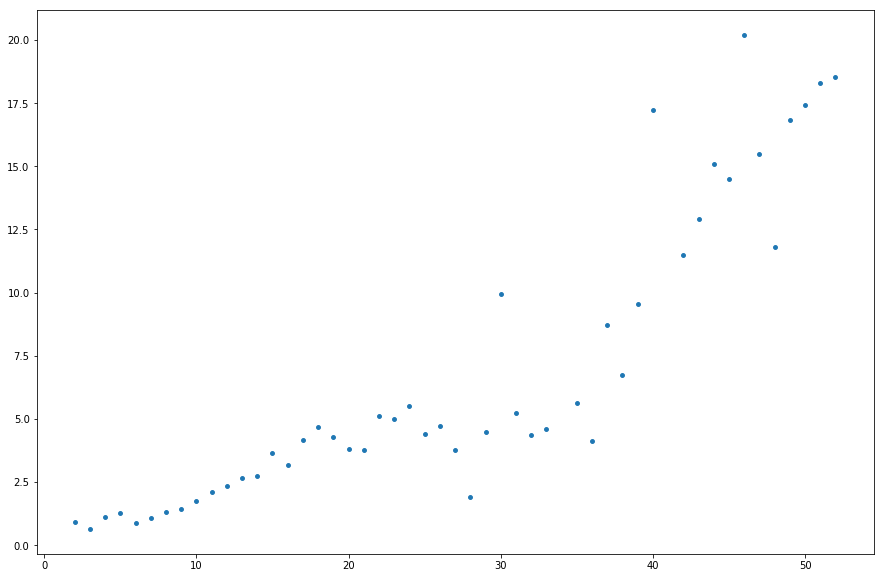

In [30]:
mean_errors=[]
x_errors=[]
for i in range(int(min(errors[:,0])), int(max(errors[:,0]))-3):
    temp_errors=errors[errors[:,0]<i+1]
    temp_errors=temp_errors[temp_errors[:,0]>i]
    if temp_errors.any()!=0:
        mean_errors.append(abs(temp_errors[:,2]).mean())
        x_errors.append(i)
plt.scatter(x_errors,mean_errors,s=15)
plt.show()

In [31]:
np.corrcoef(x=x_errors,y=mean_errors)

array([[ 1.       ,  0.8885741],
       [ 0.8885741,  1.       ]])

#### example of an image

In [1]:
fig,ax = plt.subplots(1)

NameError: name 'plt' is not defined

In [2]:
image_id=4223

In [45]:
disp_to_img = skimage.transform.resize(disp[image_id].squeeze(), [375, 1242], mode='constant')
ax.imshow(disp_to_img, cmap='plasma')

In [46]:
disp_bbox = np.array(final_boxes)[np.array(final_boxes)[:,0]==image_id]

In [47]:
disp_bbox=list(disp_bbox[0])

In [48]:
ax.add_patch(
            plt.Rectangle((disp_bbox[0+1], disp_bbox[1+1]),
                          disp_bbox[2+1] - disp_bbox[0+1],
                          disp_bbox[3+1] - disp_bbox[1+1],
                          fill=False, edgecolor='white',
                          linewidth=0.5, alpha=1))

In [49]:
depth = 0.54 * 721 / (1242 * disp_to_img) -1

In [50]:
depth[int(disp_bbox[1+1]):int(disp_bbox[3+1]),int(disp_bbox[0+1]):int(disp_bbox[2+1])].min()

6.1364343504360717

In [51]:
disp_bbox[-1]

7.4500000000000002

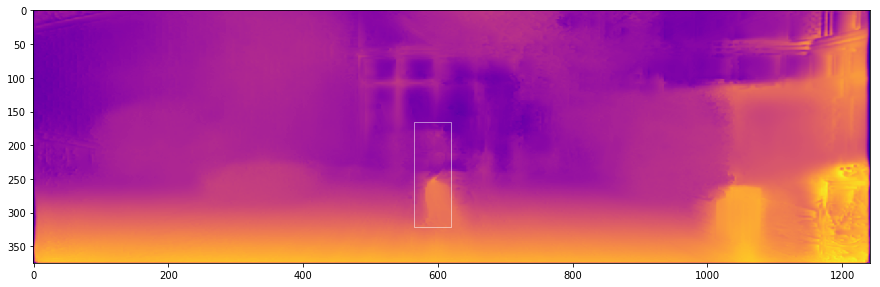

In [52]:
plt.show()

In [53]:
from IPython.display import Image

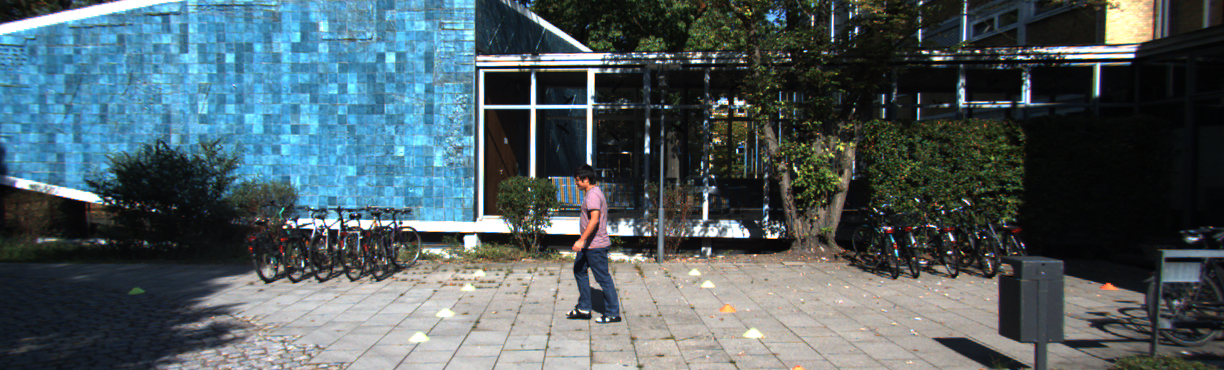

In [55]:
Image(filename = 'data/test/image_2/image_02/data/000324.png')